<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/bigearthnet%2Fvae/notebooks/Segmentation_DFC2020_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: ResNetUnet \\
Data: DFC2020 \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@bigearthnet/vae

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision bigearthnet/vae) to /tmp/pip-install-xc7cb0uk/ssl-remote-sensing_4db60349c4d4446487787be7ab5b05b4
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-xc7cb0uk/ssl-remote-sensing_4db60349c4d4446487787be7ab5b05b4
  Running command git checkout -b bigearthnet/vae --track origin/bigearthnet/vae
  Switched to a new branch 'bigearthnet/vae'
  Branch 'bigearthnet/vae' set up to track remote branch 'bigearthnet/vae' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.9 MB 31.4 MB/s 
     |████████████████████████████████| 20.9 MB 273 kB/s 
     |████████████████████████████████| 329 kB 105.5 M

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics, visualize_result
from ssl_remote_sensing.downstream_tasks.segmentation.training import train
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)
# from ssl_remote_sensing.models.ResNet18 import resnet18_encoder

/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [4]:
# resnet18_encoder(channels = 12)

In [5]:
import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [6]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
RANDOM_INITIALIZATION

'random'

In [29]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = [RANDOM_INITIALIZATION]
check_point_paths += os.listdir(g_drive_path)
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/random',
 '/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae_bigearthnet.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/bigan_encoder_allChannels_10_epochs.ckpt']

In [12]:
# check_point_paths = [
#  '/content/drive/MyDrive/deep_learning_checkpoints/random']

In [30]:
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/random',
 '/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae_bigearthnet.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/bigan_encoder_allChannels_10_epochs.ckpt']

### Hyperparameter setup

In [14]:
# Model Setup
class Hparams:
    def __init__(self):
        self.epochs = 10 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.optim = "Adam"
        self.cuda = True  # use coda
        self.transform = True
        self.split = False
        self.frozen = True

In [15]:
train_config = Hparams()

In [16]:
reproducibility(train_config)

## Data

In [17]:
dfc2020_path = '/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz'

In [18]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path='/content/')

In [19]:
from torch.utils.data import random_split

In [20]:
means = [0.1234, 0.0996, 0.0902, 0.0750, 0.0965, 0.1628, 0.1915, 0.1875, 0.2088,
        0.0708, 0.1413, 0.0873]
stds = [0.0195, 0.0260, 0.0299, 0.0453, 0.0472, 0.0878, 0.1105, 0.1125, 0.1234,
        0.0511, 0.0943, 0.0714]

In [21]:
import torchvision.transforms as transforms

if train_config.transform:

    # transform = transforms.Normalize(mean=means, std=stds)
        transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean = means,
                    std = stds) # params computed from the eurosat data
                ])
else:
    transform = None


In [22]:
dataset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True,transform = transform)
trainset, valset = random_split(dataset, [4102, 1026])

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 439889.37it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1106.tif 
 input shape: torch.Size([12, 256, 256]) 
 label shape: (256, 256) 



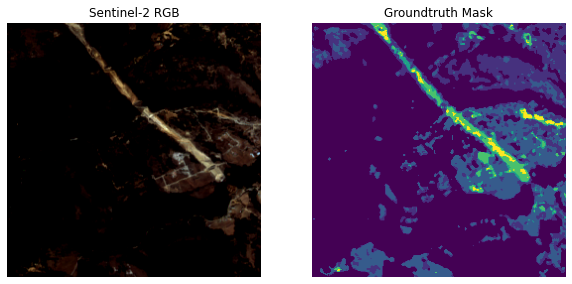

In [23]:
dataset.visualize_observation(121)

In [24]:
train_loader = DataLoader(trainset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)
val_loader = DataLoader(valset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [25]:
next(iter(train_loader))["label"].shape

torch.Size([32, 256, 256])

## Segmentation Model

In [26]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

train_acc_segmentation,▁▅▆▇▇▇▇███
train_iou_segmentation,▁▄▅▆▇▇▇███
train_loss_segmentation,█▄▃▂▂▂▁▁▁▁
val_acc_segmentation,▁▅▅▆▇▇▇███
val_iou_segmentation,▁▄▄▅▆▆▇▇██
val_loss_segmentation,█▅▄▃▂▂▂▂▁▁
train_acc_segmentation,0.85811
train_iou_segmentation,0.53543
train_loss_segmentation,0.38651
val_acc_segmentation,0.85684
val_iou_segmentation,0.53664


Validation Loss: 0.6222: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]

train_iou is 0.3391, val_iou is 0.4077
train_acc is 0.7183, val_acc is 0.7804



Validation Loss: 0.5159: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4294, val_iou is 0.4514
train_acc is 0.8000, val_acc is 0.8180


Validation Loss: 0.4633: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.4636, val_iou is 0.4624
train_acc is 0.8198, val_acc is 0.8346


Validation Loss: 0.4372: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4810, val_iou is 0.4955
train_acc is 0.8311, val_acc is 0.8441


Validation Loss: 0.4311: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.4873, val_iou is 0.5061
train_acc is 0.8331, val_acc is 0.8454


Validation Loss: 0.4152: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5087, val_iou is 0.5088
train_acc is 0.8436, val_acc is 0.8522


Validation Loss: 0.3967: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5153, val_iou is 0.5210
train_acc is 0.8494, val_acc is 0.8554


Validation Loss: 0.3747: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Saving Model...
train_iou is 0.5228, val_iou is 0.5316
train_acc is 0.8542, val_acc is 0.8634


Validation Loss: 0.3859: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]

train_iou is 0.5260, val_iou is 0.5397
train_acc is 0.8544, val_acc is 0.8575



Validation Loss: 0.4065: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


train_iou is 0.5308, val_iou is 0.5219
train_acc is 0.8565, val_acc is 0.8523
Finished Training


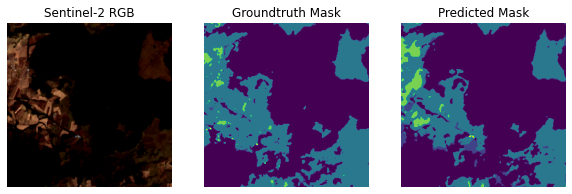

train_acc_segmentation,▁▅▆▇▇▇████
train_iou_segmentation,▁▄▆▆▆▇▇███
train_loss_segmentation,█▄▃▂▂▂▁▁▁▁
val_acc_segmentation,▁▄▆▆▆▇▇██▇
val_iou_segmentation,▁▃▄▆▆▆▇██▇
val_loss_segmentation,█▅▄▃▃▂▂▁▁▂
train_acc_segmentation,0.85648
train_iou_segmentation,0.53076
train_loss_segmentation,0.39213
val_acc_segmentation,0.85234
val_iou_segmentation,0.52189


Validation Loss: 0.5955: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]

train_iou is 0.3512, val_iou is 0.4161
train_acc is 0.7273, val_acc is 0.7895



Validation Loss: 0.5518: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4347, val_iou is 0.4485
train_acc is 0.8018, val_acc is 0.8074


Validation Loss: 0.5375: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4671, val_iou is 0.4581
train_acc is 0.8215, val_acc is 0.8087


Validation Loss: 0.4653: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4825, val_iou is 0.4774
train_acc is 0.8297, val_acc is 0.8383


Validation Loss: 0.4109: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.4986, val_iou is 0.5252
train_acc is 0.8405, val_acc is 0.8509


Validation Loss: 0.4071: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5147, val_iou is 0.5298
train_acc is 0.8487, val_acc is 0.8513


Validation Loss: 0.4030: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


Saving Model...
train_iou is 0.5240, val_iou is 0.5210
train_acc is 0.8523, val_acc is 0.8529


Validation Loss: 0.3741: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Saving Model...
train_iou is 0.5291, val_iou is 0.5358
train_acc is 0.8550, val_acc is 0.8614


Validation Loss: 0.3838: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]

train_iou is 0.5376, val_iou is 0.5425
train_acc is 0.8593, val_acc is 0.8593



Validation Loss: 0.3759: 100%|██████████| 33/33 [00:15<00:00,  2.09it/s]


train_iou is 0.5371, val_iou is 0.5451
train_acc is 0.8583, val_acc is 0.8604
Finished Training


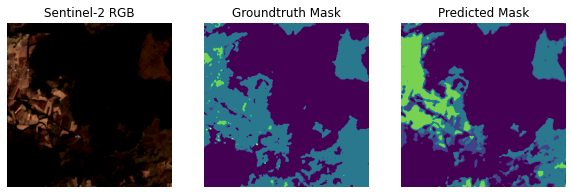

train_acc_segmentation,▁▅▆▆▇▇████
train_iou_segmentation,▁▄▅▆▇▇▇███
train_loss_segmentation,█▄▃▃▂▂▁▁▁▁
val_acc_segmentation,▁▃▃▆▇▇▇███
val_iou_segmentation,▁▃▃▄▇▇▇▇██
val_loss_segmentation,█▇▆▄▂▂▂▁▁▁
train_acc_segmentation,0.85831
train_iou_segmentation,0.53706
train_loss_segmentation,0.38402
val_acc_segmentation,0.86043
val_iou_segmentation,0.54515


Validation Loss: 0.5875: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]

train_iou is 0.3397, val_iou is 0.4368
train_acc is 0.7160, val_acc is 0.7946



Validation Loss: 0.4891: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.4506, val_iou is 0.4400
train_acc is 0.8116, val_acc is 0.8207


Validation Loss: 0.4346: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.4752, val_iou is 0.4834
train_acc is 0.8278, val_acc is 0.8421


Validation Loss: 0.4053: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.5065, val_iou is 0.5270
train_acc is 0.8444, val_acc is 0.8525


Validation Loss: 0.4154: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]

train_iou is 0.5188, val_iou is 0.5251
train_acc is 0.8500, val_acc is 0.8522



Validation Loss: 0.3886: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.5324, val_iou is 0.5255
train_acc is 0.8553, val_acc is 0.8564


Validation Loss: 0.3719: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.5354, val_iou is 0.5343
train_acc is 0.8569, val_acc is 0.8632


Validation Loss: 0.3767: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]

train_iou is 0.5440, val_iou is 0.5374
train_acc is 0.8628, val_acc is 0.8585



Validation Loss: 0.3612: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.5467, val_iou is 0.5502
train_acc is 0.8636, val_acc is 0.8653


Validation Loss: 0.3395: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.5448, val_iou is 0.5441
train_acc is 0.8630, val_acc is 0.8735
Finished Training


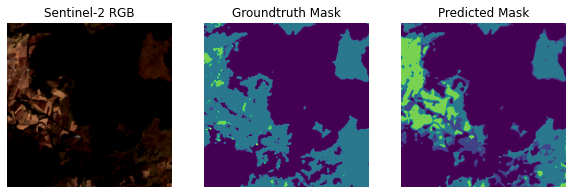

train_acc_segmentation,▁▆▆▇▇█████
train_iou_segmentation,▁▅▆▇▇█████
train_loss_segmentation,█▄▃▂▂▁▁▁▁▁
val_acc_segmentation,▁▃▅▆▆▆▇▇▇█
val_iou_segmentation,▁▁▄▇▆▆▇▇██
val_loss_segmentation,█▅▄▃▃▂▂▂▂▁
train_acc_segmentation,0.86302
train_iou_segmentation,0.54481
train_loss_segmentation,0.37439
val_acc_segmentation,0.87345
val_iou_segmentation,0.54408


Validation Loss: 0.6207: 100%|██████████| 33/33 [00:16<00:00,  2.06it/s]

train_iou is 0.3376, val_iou is 0.4171
train_acc is 0.7162, val_acc is 0.7848



Validation Loss: 0.5253: 100%|██████████| 33/33 [00:16<00:00,  2.06it/s]


Saving Model...
train_iou is 0.4288, val_iou is 0.4371
train_acc is 0.7998, val_acc is 0.8113


Validation Loss: 0.4823: 100%|██████████| 33/33 [00:16<00:00,  2.05it/s]


Saving Model...
train_iou is 0.4596, val_iou is 0.4688
train_acc is 0.8194, val_acc is 0.8254


Validation Loss: 0.4383: 100%|██████████| 33/33 [00:16<00:00,  2.06it/s]


Saving Model...
train_iou is 0.4862, val_iou is 0.4935
train_acc is 0.8320, val_acc is 0.8397


Validation Loss: 0.4189: 100%|██████████| 33/33 [00:16<00:00,  2.05it/s]


Saving Model...
train_iou is 0.4953, val_iou is 0.5099
train_acc is 0.8368, val_acc is 0.8459


Validation Loss: 0.4209: 100%|██████████| 33/33 [00:15<00:00,  2.06it/s]

train_iou is 0.5173, val_iou is 0.5091
train_acc is 0.8484, val_acc is 0.8472



Validation Loss: 0.4028: 100%|██████████| 33/33 [00:15<00:00,  2.06it/s]


Saving Model...
train_iou is 0.5217, val_iou is 0.5266
train_acc is 0.8507, val_acc is 0.8491


Validation Loss: 0.4028: 100%|██████████| 33/33 [00:16<00:00,  2.06it/s]


Saving Model...
train_iou is 0.5320, val_iou is 0.5151
train_acc is 0.8568, val_acc is 0.8528


Validation Loss: 0.3893: 100%|██████████| 33/33 [00:15<00:00,  2.06it/s]


Saving Model...
train_iou is 0.5380, val_iou is 0.5320
train_acc is 0.8593, val_acc is 0.8561


Validation Loss: 0.3733: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Saving Model...
train_iou is 0.5381, val_iou is 0.5344
train_acc is 0.8607, val_acc is 0.8603
Finished Training


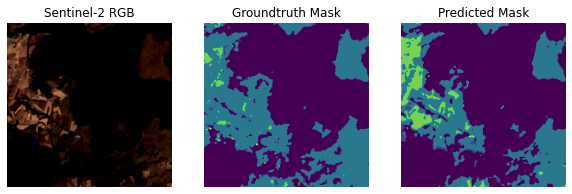

In [31]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    # patch_first_conv(encoder,13,default_in_channels=3)

    # freeze layers
    # if train_config.frozen == True:
    #     for param in encoder.parameters():
    #       param.requires_grad = False

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}_eurosat13.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation-dfc-finetune-normalize",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    
    # train(model)
    train(model,train_config,train_loader,val_loader,loss_fn,device,model_path,wandb = wandb)
    
    # Initialise a UNet() model 
    if "bigan" in train_config.checkpoint_name.lower():
        bst_model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        bst_model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    # # Load pretrained weights
    bst_model.load_state_dict(torch.load(model_path))
    # # Move to device (GPU or CPU)
    bst_model.to(device)
    # visualize_result(171,bst_model)
    visualize_result(171,bst_model,valset,device,wandb = wandb,model_name = model_name)